# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 47kB/s  eta 0:00:01    92% |█████████████████████████████▋  | 13.5MB 38.9MB/s eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

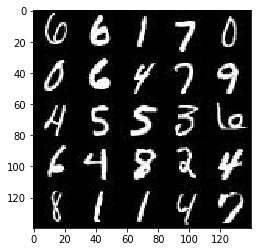

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

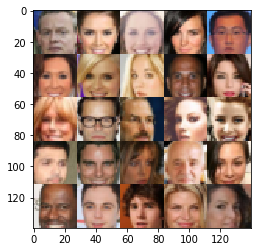

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [16]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels), name="real_input")
    z_input = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name="z_input")
    learn_rate = tf.placeholder(dtype=tf.float32, shape=(), name="learn_rate")

    return (real_input, z_input, learn_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [17]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # AE: Assuming that we'll be passing in data through the "real_input" placeholder created in the "model_inputs" above.
    # AE: In that case "images" will have this shape: shape=(None, image_width, image_height, image_channels).
    # AE: We know that both image_width=28 and image_height=28
    
    with tf.variable_scope('discriminator', reuse=reuse):    
        # AE: Let's try a convolution layer with 32 filters to start with, kernel of 3x3, strides=2x2 and ReLU activation 
        # AE: function. Image is now 28x28x3 and we'll convert it to 14x14x32
        c1 = tf.contrib.layers.conv2d(inputs=images, num_outputs=32, kernel_size=3, stride=2, padding='SAME', 
                                      activation_fn=None)
        # AE: Don't apply batch normalisation on the first convolutional layer in discriminator, they said.
        #c1 = tf.layers.batch_normalization(inputs=c1, momentum=0.99, epsilon=0.001, training=True)

        # AE: Applying leaky relu
        c1 = tf.maximum(c1 * alpha, c1)

        # AE: Input is now 14x14x32 and we'll convert it to 7x7x64
        c2 = tf.contrib.layers.conv2d(inputs=c1, num_outputs=64, kernel_size=3, stride=2, padding='SAME', activation_fn=None) # activation_fn=tf.nn.relu
        c2 = tf.layers.batch_normalization(inputs=c2, momentum=0.99, epsilon=0.001, training=True)
        # AE: Applying leaky relu
        c2 = tf.maximum(c2 * alpha, c2)
        
        #print("C2 shape: ", c2.get_shape())
        
        # AE: Input is now 7x7x64 and we'll convert it to 3x3x128
        # AE: We'll be using padding='VALID' here to drop the remaining pixel when we want to downscale 7x7 image into
        # AE: a 3x3 one. That way the kernel window will ignore the last row and last column, instead of adding an extra
        # AE: one with a copy of the previous row and column.
        c3 = tf.contrib.layers.conv2d(inputs=c2, num_outputs=128, kernel_size=3, stride=2, padding='SAME', activation_fn=None) # activation_fn=tf.nn.relu
        c3 = tf.layers.batch_normalization(inputs=c3, momentum=0.99, epsilon=0.001, training=True)
        # AE: Applying leaky relu
        c3 = tf.maximum(c3 * alpha, c3)
        
        #print("C3 shape: ", c3.get_shape())
        
        # AE: Now let's flatten it and get a single result through a dense layer:
        c3 = tf.reshape(c3, (-1, 4 * 4 * 128))
        logits = tf.layers.dense(inputs=c3, units=1, activation=None, use_bias=True)
        
        output = tf.sigmoid(logits)
        
    
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [26]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        # AE: Let's start with a dense layer where we'll load in z and stretch it to a starting shape of 2x2x512
        fc = tf.layers.dense(inputs=z, units=512 * 2 * 2, activation=None, use_bias=True)

        # AE: Now turn it into the correct shape
        fc = tf.reshape(fc, [-1, 2, 2, 512])
        # AE: Now batch normalisation
        fcbn = tf.layers.batch_normalization(inputs=fc, momentum=0.99, epsilon=0.001, training=is_train)
        # AE: Leaky ReLU
        fcbnlr = tf.maximum(fcbn * alpha, fcbn)
        #print(fcbnlr.shape)

        # AE: And off we go with the convolutional transpose layers to downscale number of filters and make our picture emerge
        # AE: Our random values are now shaped: 2x2x512. Let's get them into 4x4x256
        ct1 = tf.contrib.layers.conv2d_transpose(inputs=fcbnlr, num_outputs=256, kernel_size=3, stride=2, 
                                                 padding='SAME', activation_fn=None) #data_format=DATA_FORMAT_NHWC, activation_fn=tf.nn.relu,
        #activation_fn=tf.nn.relu, weights_initializer=tf.contrib.layers.xavier_initializer()
        
        # AE: Adding a drop out layer to imporove generator's strength agains discriminator
        #ct1 = tf.layers.dropout(inputs=ct1, rate=0.3)
        
        # AE: Batch normalisation
        ct1bn = tf.layers.batch_normalization(inputs=ct1, momentum=0.99, epsilon=0.001, training=is_train)
        # AE: Leaky ReLU
        ct1bnlr = tf.maximum(ct1bn * alpha, ct1bn)
        
        #print(ct1bnlr.shape)
        
        # AE: 4x4x256 -> 8x8x128
        ct2 = tf.contrib.layers.conv2d_transpose(inputs=ct1bnlr, num_outputs=128, kernel_size=3, stride=2, 
                                                 padding='SAME', activation_fn=None)
        #ct2 = tf.layers.dropout(inputs=ct2, rate=0.3)
        ct2bn = tf.layers.batch_normalization(inputs=ct2, momentum=0.99, epsilon=0.001, training=is_train)
        ct2bnlr = tf.maximum(ct2bn * alpha, ct2bn)
        
        #print(ct2bnlr.shape)

        # AE: 8x8x128 -> 16x16x64
        ct3 = tf.contrib.layers.conv2d_transpose(inputs=ct2bnlr, num_outputs=64, kernel_size=3, stride=2, 
                                                 padding='SAME', activation_fn=None)
        #ct3 = tf.layers.dropout(inputs=ct3, rate=0.3)
        ct3bn = tf.layers.batch_normalization(inputs=ct3, momentum=0.99, epsilon=0.001, training=is_train)
        ct3bnlr = tf.maximum(ct3bn * alpha, ct3bn)
        
        #print(ct3bnlr.shape)

        # AE: 16x16x128 -> 32x32x3 (or 32x32x1 in case of MNIST)
        ct4 = tf.contrib.layers.conv2d_transpose(inputs=ct3bnlr, num_outputs=out_channel_dim, kernel_size=3, stride=2, 
                                                 padding='SAME', activation_fn=None)
        
        # AE: now we have 32x32x3 shape, but we want 28x28x3. We could flatten, then drop values from the tail, then 
        # AE: reshape back, but that would brutally change the content of the dimensions. Maybe instead we could 
        # AE: carefully carve out what we want through slicing. And of course we want tanh activation.
        output = tf.tanh(ct4)
        output = output[:, :28, :28, :]
        #output_flattened = tf.flatten(output)
        #print(output.shape, " out_channel_dim=", out_channel_dim)
        
        #print("0: ", output[0][0][0].shape, "1: ", output[1].shape, "2: ", output[2].shape, "3: ", output[3].shape)
        #print("0: ", output[28:][28:][0])
        #print("0ut: ", output[:, :28, :28, :])
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [27]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # AE: In essence we want to create a generator and discriminator, then feed the input_z to the generator,
    # AE: then feed generator's output to the discriminator, then the output of the disciminator (assuming 1 means
    # AE: natural picture and 0-artificial) is discriminator's loss. Generator's loss is discriminator's output 
    # AE: subtracted from 1. Discriminator should also be tested against the real image and its result subtracted from
    # AE: 1. That will be discrimantor's loss for real images. Both discriminator's losses need to be summed to take both 
    # AE: of them into account (should they be aggregated?).
    # AE:
    # AE: We want generator to NOT re-use the variables, because ... not sure?? ... so setting is_train=True.
    g = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    # AE: The first discriminator should NOT re-use variables, because they have not been set up yet.
    d_artificial, d_a_logits = discriminator(g, reuse=False, alpha=alpha)
    # AE: The second discriminator SHOULD re-use variables from the first discriminator 
    d_real, d_r_logits = discriminator(input_real, reuse=True, alpha=alpha)
    

    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_a_logits, labels=tf.zeros_like(d_artificial)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_a_logits, labels=tf.ones_like(d_artificial)))
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_r_logits, labels=tf.ones_like(d_real)))

    d_loss = d_loss_real + d_loss_fake

    #g_loss = 1 - d_a_logits
    #d_loss = d_a_logits + (1 - d_r_logits)
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [28]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # AE: Let's use Adam optimiser on the loss that we calculated earlier and let the optimiser change the variables
    # AE: that we get from tf.trainable_variables
    all_vars = tf.trainable_variables()
    d_vars = [var for var in all_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in all_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    return (d_opt, g_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [29]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [30]:
# AE: To implement train method, I need to know for sure how the datasets look like.

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
print("MNIST shape and mode: ", mnist_dataset.shape, mnist_dataset.image_mode)

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
print("CELEBA shape and mode: ", celeba_dataset.shape, celeba_dataset.image_mode)

MNIST shape and mode:  (60000, 28, 28, 1) L
CELEBA shape and mode:  (202599, 28, 28, 3) RGB


In [31]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha=0.2):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    img_width = data_shape[1]
    img_height = data_shape[2]
    out_channel_dim = data_shape[3]

    # AE: placeholders, which we'll change when training (feed into the TF session)
    real_input, z_input, learn_rate = model_inputs(img_width, img_height, out_channel_dim, z_dim)

    # AE: And now the model taking in the placeholders
    d_loss, g_loss = model_loss(real_input, z_input, out_channel_dim, alpha=alpha)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)

    # AE: number of batches pushed through our model
    batches_pushed = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                # AE: We have a batch of real images in the batch_images, but we also need a batch of random vectors
                # AE: to give to the generator. Both batches of course need to be the same size.
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # AE: Now we can run generator and discriminator in the TF session, passing in the pictures and the random
                # AE: vectors, then evaluating loss, optimising and training
                _ = sess.run(g_opt, feed_dict={z_input: batch_z, real_input: batch_images, learn_rate: learning_rate})
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: batch_z, learn_rate: learning_rate})
                
                # AE: Training the generator an extra time, because it appears to be weak.
                #_ = sess.run(g_opt, feed_dict={z_input: batch_z, real_input: batch_images, learn_rate: learning_rate})

                # AE: Every 10 batches we can print out training statistics
                if (batches_pushed != 0 and batches_pushed % 10 == 0):
                    train_loss_g = g_loss.eval(feed_dict={z_input: batch_z, real_input: batch_images, learn_rate: learning_rate})
                    train_loss_d = d_loss.eval(feed_dict={z_input: batch_z, real_input: batch_images, learn_rate: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count), " D loss: {:.4f}".format(train_loss_d),
                         " G loss: {:.4f}".format(train_loss_g))

                # AE: And every 100 batches we could show the images that we can now generate
                if (batches_pushed != 0 and batches_pushed % 100 == 0):
                    show_generator_output(sess=sess, n_images=9, input_z=z_input, 
                                          out_channel_dim=out_channel_dim, image_mode=data_image_mode)
                
                # AE: Another batch has been pushed through our model
                batches_pushed += 1
                
        # AE: Also display generator's output at the very end
        show_generator_output(sess=sess, n_images=9, input_z=z_input, out_channel_dim=out_channel_dim, 
                              image_mode=data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2...  D loss: 3.3147  G loss: 0.0572
Epoch 1/2...  D loss: 2.3569  G loss: 0.1632
Epoch 1/2...  D loss: 1.8217  G loss: 0.3423
Epoch 1/2...  D loss: 1.2992  G loss: 0.7470
Epoch 1/2...  D loss: 1.1262  G loss: 0.8821
Epoch 1/2...  D loss: 1.3029  G loss: 0.9538
Epoch 1/2...  D loss: 1.0706  G loss: 1.2212
Epoch 1/2...  D loss: 1.1338  G loss: 1.1605
Epoch 1/2...  D loss: 1.2638  G loss: 1.1402
Epoch 1/2...  D loss: 1.1919  G loss: 1.2265


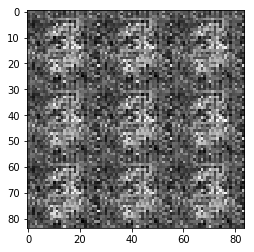

Epoch 1/2...  D loss: 1.2136  G loss: 1.2852
Epoch 1/2...  D loss: 1.4573  G loss: 1.2371
Epoch 1/2...  D loss: 1.2325  G loss: 1.3403
Epoch 1/2...  D loss: 1.2687  G loss: 1.3701
Epoch 1/2...  D loss: 1.1749  G loss: 1.2422
Epoch 1/2...  D loss: 1.0944  G loss: 1.3922
Epoch 1/2...  D loss: 0.9550  G loss: 1.3999
Epoch 1/2...  D loss: 0.9214  G loss: 1.4723
Epoch 1/2...  D loss: 0.8046  G loss: 1.5097
Epoch 1/2...  D loss: 0.6892  G loss: 1.6404


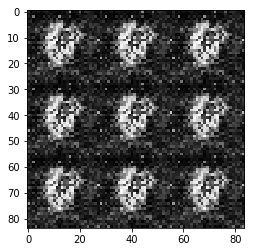

Epoch 1/2...  D loss: 0.6044  G loss: 1.7659
Epoch 1/2...  D loss: 0.6099  G loss: 1.7449
Epoch 1/2...  D loss: 0.5670  G loss: 1.8094
Epoch 1/2...  D loss: 0.5684  G loss: 1.9721
Epoch 1/2...  D loss: 0.6635  G loss: 1.8396
Epoch 1/2...  D loss: 0.7844  G loss: 1.7216
Epoch 1/2...  D loss: 0.5668  G loss: 1.9165
Epoch 1/2...  D loss: 0.6050  G loss: 1.6861
Epoch 1/2...  D loss: 0.4652  G loss: 1.9359
Epoch 1/2...  D loss: 0.3991  G loss: 2.1053


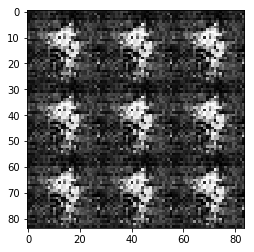

Epoch 1/2...  D loss: 0.4511  G loss: 2.1133
Epoch 1/2...  D loss: 0.5538  G loss: 1.9621
Epoch 1/2...  D loss: 0.4546  G loss: 2.0427
Epoch 1/2...  D loss: 0.4292  G loss: 2.1747
Epoch 1/2...  D loss: 0.3845  G loss: 2.1239
Epoch 1/2...  D loss: 0.4370  G loss: 2.0546
Epoch 1/2...  D loss: 0.3545  G loss: 2.2000
Epoch 1/2...  D loss: 0.3507  G loss: 2.2835
Epoch 1/2...  D loss: 0.3277  G loss: 2.3822
Epoch 1/2...  D loss: 0.4193  G loss: 2.3836


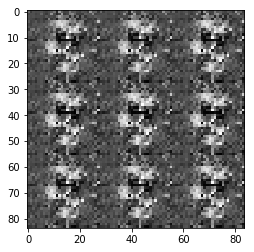

Epoch 1/2...  D loss: 0.3149  G loss: 2.3180
Epoch 1/2...  D loss: 0.4649  G loss: 2.2346
Epoch 1/2...  D loss: 0.4120  G loss: 2.3033
Epoch 1/2...  D loss: 0.3715  G loss: 2.1881
Epoch 1/2...  D loss: 0.4355  G loss: 2.3143
Epoch 1/2...  D loss: 0.6992  G loss: 2.7431
Epoch 2/2...  D loss: 0.9312  G loss: 2.4545
Epoch 2/2...  D loss: 0.5724  G loss: 1.9526
Epoch 2/2...  D loss: 0.8020  G loss: 2.3872
Epoch 2/2...  D loss: 0.5922  G loss: 2.0898


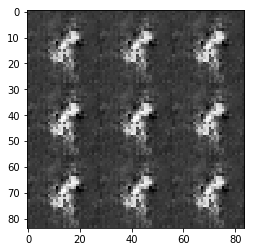

Epoch 2/2...  D loss: 0.5632  G loss: 1.7351
Epoch 2/2...  D loss: 0.4391  G loss: 2.1878
Epoch 2/2...  D loss: 0.4930  G loss: 2.0536
Epoch 2/2...  D loss: 0.4932  G loss: 1.9818
Epoch 2/2...  D loss: 0.3709  G loss: 2.2707
Epoch 2/2...  D loss: 0.4620  G loss: 2.1237
Epoch 2/2...  D loss: 0.5766  G loss: 1.8668
Epoch 2/2...  D loss: 0.4451  G loss: 2.2097
Epoch 2/2...  D loss: 0.4477  G loss: 2.2467
Epoch 2/2...  D loss: 0.4250  G loss: 2.2393


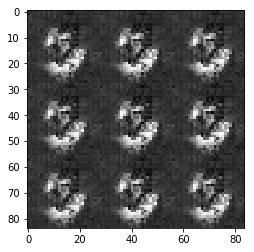

Epoch 2/2...  D loss: 0.3741  G loss: 2.4802
Epoch 2/2...  D loss: 0.3926  G loss: 2.3378
Epoch 2/2...  D loss: 0.3800  G loss: 2.3028
Epoch 2/2...  D loss: 0.3081  G loss: 2.5404
Epoch 2/2...  D loss: 0.5209  G loss: 2.6350
Epoch 2/2...  D loss: 0.4502  G loss: 2.1597
Epoch 2/2...  D loss: 0.4583  G loss: 2.3734
Epoch 2/2...  D loss: 0.3382  G loss: 2.5331
Epoch 2/2...  D loss: 0.3130  G loss: 2.7320
Epoch 2/2...  D loss: 0.2566  G loss: 2.4772


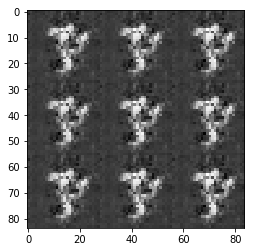

Epoch 2/2...  D loss: 0.3266  G loss: 2.5113
Epoch 2/2...  D loss: 0.2844  G loss: 2.3020
Epoch 2/2...  D loss: 0.2934  G loss: 2.1938
Epoch 2/2...  D loss: 0.2772  G loss: 2.6343
Epoch 2/2...  D loss: 0.1991  G loss: 2.7820
Epoch 2/2...  D loss: 0.1840  G loss: 2.6108
Epoch 2/2...  D loss: 0.2589  G loss: 2.5902
Epoch 2/2...  D loss: 0.1894  G loss: 2.8605
Epoch 2/2...  D loss: 0.2118  G loss: 3.1428
Epoch 2/2...  D loss: 0.3420  G loss: 2.8202


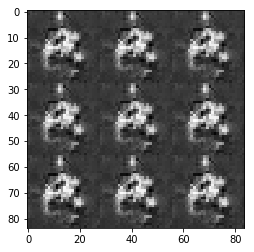

Epoch 2/2...  D loss: 0.5539  G loss: 1.7486
Epoch 2/2...  D loss: 0.3492  G loss: 2.4114
Epoch 2/2...  D loss: 0.3296  G loss: 2.2466
Epoch 2/2...  D loss: 0.2970  G loss: 2.5990
Epoch 2/2...  D loss: 0.3632  G loss: 2.4432
Epoch 2/2...  D loss: 0.4142  G loss: 3.3501
Epoch 2/2...  D loss: 0.4256  G loss: 2.4902
Epoch 2/2...  D loss: 0.3869  G loss: 2.3153
Epoch 2/2...  D loss: 0.3283  G loss: 2.7951
Epoch 2/2...  D loss: 0.2791  G loss: 2.6962


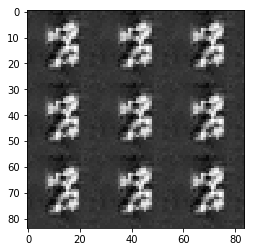

Epoch 2/2...  D loss: 0.2605  G loss: 2.9908
Epoch 2/2...  D loss: 0.1940  G loss: 2.7968
Epoch 2/2...  D loss: 0.2216  G loss: 2.5083


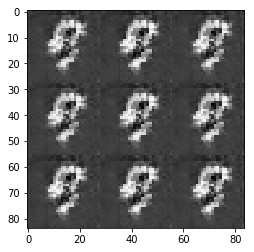

In [32]:
# AE: Just some starting values. Trying to fill the z vector with as many random values as will be used. Introduced 
# AE: configurable alpha, reduced learning rate
#batch_size = 500
#z_dim = 1024
#learning_rate = 0.01
#beta1 = 0.4
#alpha=0.2

# AE: Generator loss was well above discriminator's. So I train the generator twice as much now and it seems to have improved
# AE: things, but generated pictures are still quite poor. Increasing beta value and giving more random values for z 
# AE: (the maximum now as it will only suse 512x2x2 values)
#batch_size = 500
#z_dim = 2048
#learning_rate = 0.01
#beta1 = 0.5
#alpha=0.2

# AE: Still bad, reducing learning rate.
#batch_size = 500
#z_dim = 2048
#learning_rate = 0.001
#beta1 = 0.5
#alpha=0.2

# AE: Still bad, increasing batch size and reducing random values in z vector.
#batch_size = 1200
#z_dim = 256
#learning_rate = 0.001
#beta1 = 0.5
#alpha=0.2

# AE: Still bad, going with values from DCGAN (house numbers) mini project.
#batch_size = 128
#z_dim = 100
#learning_rate = 0.0002
#beta1 = 0.5
#alpha=0.2

# AE: That was almost good. It generated decent enough 0 digits. Let's increase randomization in z vector.
#batch_size = 128
#z_dim = 512
#learning_rate = 0.0002
#beta1 = 0.5
#alpha=0.2

# AE: Worse again, reducing z vector randomisation and trying without the extra training step for generator.
#batch_size = 128
#z_dim = 100
#learning_rate = 0.0002
#beta1 = 0.5
#alpha=0.2

# AE: Just trying different lr, beta and alpha.
#batch_size = 128
#z_dim = 100
#learning_rate = 0.0003
#beta1 = 0.6
#alpha=0.1

# AE: Going back to what almost worked. Also, introduced xavier initialisation for Generator's con2d_transpose layers' weights,
# AE: also introduced ReLU activation function on the same layers.
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
alpha=0.2

# AE: Finally out of desperation I included drop out layers in generator and changed the discriminator to take into account
# AE: all values in the final layer before output (by using padding='SAME' instead of 'VALID')

# AE: Removed the dropout layers and xavier initialisation from the generator, because it didn't seem to help generating faces

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha=alpha)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2...  D loss: 3.0057  G loss: 0.1039
Epoch 1/2...  D loss: 2.5748  G loss: 0.1829
Epoch 1/2...  D loss: 2.3456  G loss: 0.2668
Epoch 1/2...  D loss: 1.8520  G loss: 0.4975
Epoch 1/2...  D loss: 2.0659  G loss: 0.4361
Epoch 1/2...  D loss: 2.0051  G loss: 0.5225
Epoch 1/2...  D loss: 2.2349  G loss: 0.6410
Epoch 1/2...  D loss: 2.0289  G loss: 0.7489
Epoch 1/2...  D loss: 1.7816  G loss: 0.9782
Epoch 1/2...  D loss: 1.6946  G loss: 0.9894


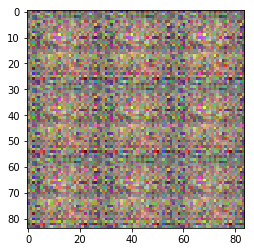

Epoch 1/2...  D loss: 1.4932  G loss: 1.0453
Epoch 1/2...  D loss: 1.6313  G loss: 1.1318
Epoch 1/2...  D loss: 1.1841  G loss: 1.4174
Epoch 1/2...  D loss: 1.0825  G loss: 1.3662
Epoch 1/2...  D loss: 1.1826  G loss: 1.4071
Epoch 1/2...  D loss: 0.9482  G loss: 1.4993
Epoch 1/2...  D loss: 1.0429  G loss: 1.4465
Epoch 1/2...  D loss: 0.9039  G loss: 1.4523
Epoch 1/2...  D loss: 1.1210  G loss: 1.3939
Epoch 1/2...  D loss: 1.2803  G loss: 1.2395


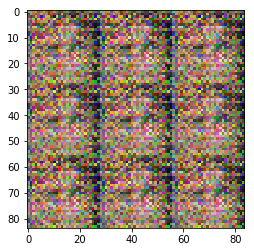

Epoch 1/2...  D loss: 1.2431  G loss: 1.4160
Epoch 1/2...  D loss: 0.8591  G loss: 1.6357
Epoch 1/2...  D loss: 0.7834  G loss: 1.6387
Epoch 1/2...  D loss: 0.8307  G loss: 1.6062
Epoch 1/2...  D loss: 0.7690  G loss: 1.6281
Epoch 1/2...  D loss: 0.8698  G loss: 1.5585
Epoch 1/2...  D loss: 0.8413  G loss: 1.5662
Epoch 1/2...  D loss: 0.9073  G loss: 1.6048
Epoch 1/2...  D loss: 0.8590  G loss: 1.6046
Epoch 1/2...  D loss: 0.9609  G loss: 1.5621


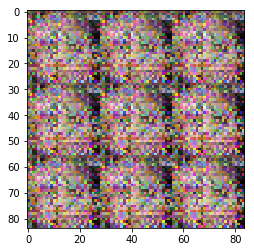

Epoch 1/2...  D loss: 1.0127  G loss: 1.4000
Epoch 1/2...  D loss: 0.7689  G loss: 1.6173
Epoch 1/2...  D loss: 0.9510  G loss: 1.4405
Epoch 1/2...  D loss: 0.9632  G loss: 1.4909
Epoch 1/2...  D loss: 0.8529  G loss: 1.5617
Epoch 1/2...  D loss: 0.6970  G loss: 1.6490
Epoch 1/2...  D loss: 0.7556  G loss: 1.5632
Epoch 1/2...  D loss: 0.7495  G loss: 1.6499
Epoch 1/2...  D loss: 0.6510  G loss: 1.7906
Epoch 1/2...  D loss: 0.5366  G loss: 1.9037


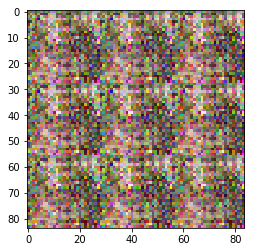

Epoch 1/2...  D loss: 0.5458  G loss: 1.9850
Epoch 1/2...  D loss: 0.6930  G loss: 2.1067
Epoch 1/2...  D loss: 0.3976  G loss: 2.1747
Epoch 1/2...  D loss: 0.3965  G loss: 2.1339
Epoch 1/2...  D loss: 0.4091  G loss: 2.3159
Epoch 1/2...  D loss: 0.4489  G loss: 2.0755
Epoch 1/2...  D loss: 0.4920  G loss: 2.0690
Epoch 1/2...  D loss: 0.5484  G loss: 1.9887
Epoch 1/2...  D loss: 0.6606  G loss: 1.8098
Epoch 1/2...  D loss: 0.7439  G loss: 1.7265


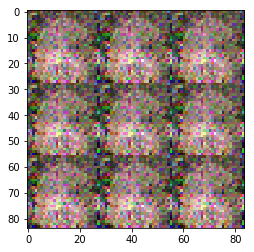

Epoch 1/2...  D loss: 0.7435  G loss: 1.8182
Epoch 1/2...  D loss: 0.5100  G loss: 1.8477
Epoch 1/2...  D loss: 0.6044  G loss: 1.7833
Epoch 1/2...  D loss: 0.6417  G loss: 1.6567
Epoch 1/2...  D loss: 0.6742  G loss: 1.7339
Epoch 1/2...  D loss: 0.4853  G loss: 1.9765
Epoch 1/2...  D loss: 0.4552  G loss: 2.0222
Epoch 1/2...  D loss: 0.3511  G loss: 2.3384
Epoch 1/2...  D loss: 0.5960  G loss: 2.2361
Epoch 1/2...  D loss: 0.6898  G loss: 1.9831


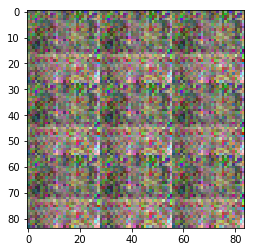

Epoch 1/2...  D loss: 0.5333  G loss: 2.1458
Epoch 1/2...  D loss: 0.4669  G loss: 2.4212
Epoch 1/2...  D loss: 0.4792  G loss: 1.9473
Epoch 1/2...  D loss: 0.6664  G loss: 2.0929
Epoch 1/2...  D loss: 0.5418  G loss: 2.1493
Epoch 1/2...  D loss: 0.5254  G loss: 2.0558
Epoch 1/2...  D loss: 0.4227  G loss: 2.0660
Epoch 1/2...  D loss: 0.4658  G loss: 2.1074
Epoch 1/2...  D loss: 0.6012  G loss: 2.0914
Epoch 1/2...  D loss: 0.5297  G loss: 2.0914


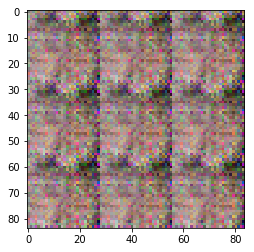

Epoch 1/2...  D loss: 0.5000  G loss: 2.1545
Epoch 1/2...  D loss: 0.5145  G loss: 1.9823
Epoch 1/2...  D loss: 0.3943  G loss: 2.2658
Epoch 1/2...  D loss: 0.2684  G loss: 2.4902
Epoch 1/2...  D loss: 0.3249  G loss: 2.3982
Epoch 1/2...  D loss: 0.4049  G loss: 2.2691
Epoch 1/2...  D loss: 0.6254  G loss: 2.1014
Epoch 1/2...  D loss: 0.7397  G loss: 1.6878
Epoch 1/2...  D loss: 0.5594  G loss: 1.7925
Epoch 1/2...  D loss: 0.5404  G loss: 1.8216


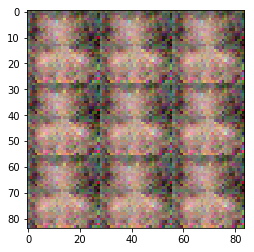

Epoch 1/2...  D loss: 0.6123  G loss: 1.7481
Epoch 1/2...  D loss: 0.5290  G loss: 1.8355
Epoch 1/2...  D loss: 0.2917  G loss: 2.2775
Epoch 1/2...  D loss: 0.3569  G loss: 2.3315
Epoch 1/2...  D loss: 0.3010  G loss: 2.6709
Epoch 1/2...  D loss: 0.3541  G loss: 2.4444
Epoch 1/2...  D loss: 0.3111  G loss: 2.3010
Epoch 1/2...  D loss: 0.4687  G loss: 1.9739
Epoch 1/2...  D loss: 0.7926  G loss: 2.0237
Epoch 1/2...  D loss: 0.6918  G loss: 1.8161


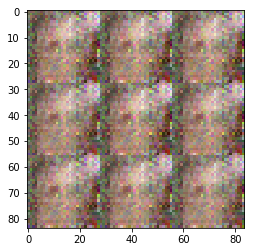

Epoch 1/2...  D loss: 0.4029  G loss: 2.1785
Epoch 1/2...  D loss: 0.3284  G loss: 2.4694
Epoch 1/2...  D loss: 0.3685  G loss: 2.3736
Epoch 1/2...  D loss: 0.5432  G loss: 2.3028
Epoch 1/2...  D loss: 0.5768  G loss: 1.8970
Epoch 1/2...  D loss: 0.5989  G loss: 1.7736
Epoch 1/2...  D loss: 0.5216  G loss: 1.8343
Epoch 1/2...  D loss: 0.4946  G loss: 2.1853
Epoch 1/2...  D loss: 0.3094  G loss: 2.4700
Epoch 1/2...  D loss: 0.3202  G loss: 2.2434


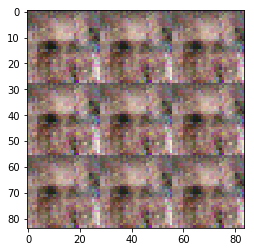

Epoch 1/2...  D loss: 0.4570  G loss: 2.4472
Epoch 1/2...  D loss: 0.8880  G loss: 2.4774
Epoch 1/2...  D loss: 0.6242  G loss: 2.0176
Epoch 1/2...  D loss: 0.5473  G loss: 1.9514
Epoch 1/2...  D loss: 0.3862  G loss: 2.3222
Epoch 1/2...  D loss: 0.4009  G loss: 2.1586
Epoch 1/2...  D loss: 0.4791  G loss: 2.2617
Epoch 1/2...  D loss: 0.4251  G loss: 2.3130
Epoch 1/2...  D loss: 0.5192  G loss: 2.0734
Epoch 1/2...  D loss: 0.4962  G loss: 2.2193


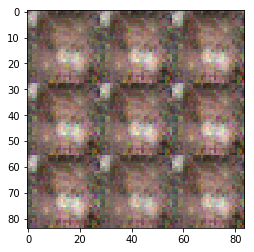

Epoch 1/2...  D loss: 0.5422  G loss: 2.1768
Epoch 1/2...  D loss: 0.3160  G loss: 2.4591
Epoch 1/2...  D loss: 0.3620  G loss: 2.3770
Epoch 1/2...  D loss: 0.3328  G loss: 2.5055
Epoch 1/2...  D loss: 0.3047  G loss: 2.5203
Epoch 1/2...  D loss: 0.4384  G loss: 2.3267
Epoch 1/2...  D loss: 0.5320  G loss: 1.8907
Epoch 1/2...  D loss: 0.2789  G loss: 2.3763
Epoch 1/2...  D loss: 0.2926  G loss: 2.4651
Epoch 1/2...  D loss: 0.3881  G loss: 2.2430


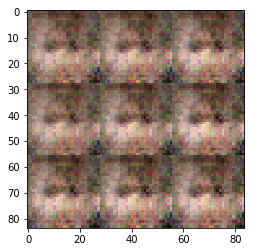

Epoch 1/2...  D loss: 0.4848  G loss: 2.1876
Epoch 1/2...  D loss: 0.3601  G loss: 2.3795
Epoch 1/2...  D loss: 0.2767  G loss: 2.7028
Epoch 1/2...  D loss: 0.2435  G loss: 2.6764
Epoch 1/2...  D loss: 0.2546  G loss: 2.5575
Epoch 1/2...  D loss: 0.3771  G loss: 2.4620
Epoch 1/2...  D loss: 0.3602  G loss: 2.3085
Epoch 1/2...  D loss: 0.3133  G loss: 2.2711
Epoch 1/2...  D loss: 0.4027  G loss: 2.2922
Epoch 1/2...  D loss: 0.2935  G loss: 2.4281


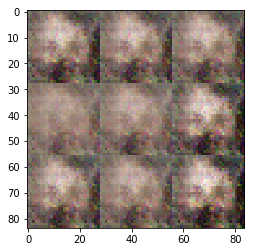

Epoch 1/2...  D loss: 0.3264  G loss: 2.4095
Epoch 1/2...  D loss: 0.7815  G loss: 1.4638
Epoch 1/2...  D loss: 1.2724  G loss: 1.1785
Epoch 1/2...  D loss: 1.2072  G loss: 0.9447
Epoch 1/2...  D loss: 1.2200  G loss: 0.9787
Epoch 1/2...  D loss: 1.1260  G loss: 0.8347
Epoch 1/2...  D loss: 1.0805  G loss: 0.9219
Epoch 1/2...  D loss: 0.9212  G loss: 1.1866
Epoch 1/2...  D loss: 1.0566  G loss: 0.9159
Epoch 1/2...  D loss: 1.0999  G loss: 0.9096


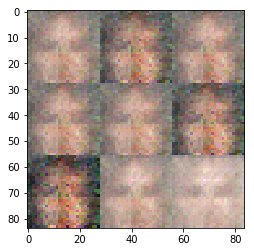

Epoch 1/2...  D loss: 1.0085  G loss: 1.0906
Epoch 1/2...  D loss: 0.7812  G loss: 1.2130
Epoch 1/2...  D loss: 0.7794  G loss: 1.2544
Epoch 1/2...  D loss: 0.7628  G loss: 1.5155
Epoch 1/2...  D loss: 0.9589  G loss: 1.4074
Epoch 1/2...  D loss: 0.9503  G loss: 1.1158
Epoch 1/2...  D loss: 0.6861  G loss: 1.6474
Epoch 1/2...  D loss: 0.7101  G loss: 1.5256
Epoch 1/2...  D loss: 0.8635  G loss: 1.1519
Epoch 1/2...  D loss: 1.0041  G loss: 1.3154


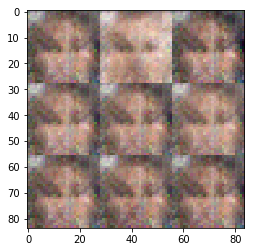

Epoch 1/2...  D loss: 0.6321  G loss: 1.7843
Epoch 1/2...  D loss: 1.0391  G loss: 1.2598
Epoch 1/2...  D loss: 0.9398  G loss: 1.0927
Epoch 1/2...  D loss: 1.0738  G loss: 1.0242
Epoch 1/2...  D loss: 1.1015  G loss: 0.8991
Epoch 1/2...  D loss: 1.1663  G loss: 1.0247
Epoch 1/2...  D loss: 1.0559  G loss: 1.2715
Epoch 1/2...  D loss: 1.2510  G loss: 1.1728
Epoch 2/2...  D loss: 1.1670  G loss: 0.8882
Epoch 2/2...  D loss: 1.1113  G loss: 0.9607


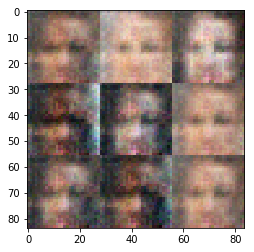

Epoch 2/2...  D loss: 1.3224  G loss: 0.7814
Epoch 2/2...  D loss: 1.1596  G loss: 0.8333
Epoch 2/2...  D loss: 1.3528  G loss: 0.8739
Epoch 2/2...  D loss: 1.1196  G loss: 1.0088
Epoch 2/2...  D loss: 1.2286  G loss: 0.8925
Epoch 2/2...  D loss: 1.4331  G loss: 0.8628
Epoch 2/2...  D loss: 1.2859  G loss: 0.8352
Epoch 2/2...  D loss: 1.3372  G loss: 0.8728
Epoch 2/2...  D loss: 1.2648  G loss: 0.9575
Epoch 2/2...  D loss: 1.1983  G loss: 0.9335


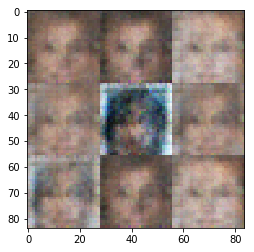

Epoch 2/2...  D loss: 1.3220  G loss: 1.0113
Epoch 2/2...  D loss: 1.4127  G loss: 0.9230
Epoch 2/2...  D loss: 1.0257  G loss: 1.0953
Epoch 2/2...  D loss: 1.2666  G loss: 0.8666
Epoch 2/2...  D loss: 1.1433  G loss: 1.0835
Epoch 2/2...  D loss: 1.2004  G loss: 0.8329
Epoch 2/2...  D loss: 1.1409  G loss: 0.9585
Epoch 2/2...  D loss: 1.2599  G loss: 0.8494
Epoch 2/2...  D loss: 1.1725  G loss: 1.0475
Epoch 2/2...  D loss: 1.1566  G loss: 0.9764


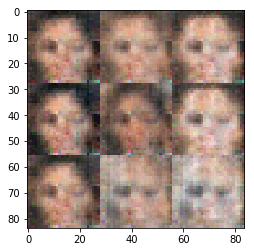

Epoch 2/2...  D loss: 1.0515  G loss: 1.0755
Epoch 2/2...  D loss: 1.3247  G loss: 0.8921
Epoch 2/2...  D loss: 1.0838  G loss: 1.0097
Epoch 2/2...  D loss: 1.0727  G loss: 1.1173
Epoch 2/2...  D loss: 1.1533  G loss: 1.1351
Epoch 2/2...  D loss: 1.1351  G loss: 0.9823
Epoch 2/2...  D loss: 1.0973  G loss: 1.0531
Epoch 2/2...  D loss: 1.1988  G loss: 1.0827
Epoch 2/2...  D loss: 1.1818  G loss: 1.0713
Epoch 2/2...  D loss: 1.0983  G loss: 1.1369


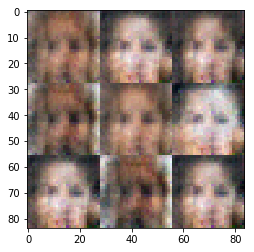

Epoch 2/2...  D loss: 1.0469  G loss: 0.9943
Epoch 2/2...  D loss: 1.2105  G loss: 0.8163
Epoch 2/2...  D loss: 1.0335  G loss: 1.0800
Epoch 2/2...  D loss: 1.0915  G loss: 1.0773
Epoch 2/2...  D loss: 1.0549  G loss: 1.0673
Epoch 2/2...  D loss: 0.9344  G loss: 1.1503
Epoch 2/2...  D loss: 1.0787  G loss: 0.9753
Epoch 2/2...  D loss: 1.1030  G loss: 1.0910
Epoch 2/2...  D loss: 1.0707  G loss: 0.9642
Epoch 2/2...  D loss: 0.8542  G loss: 1.1128


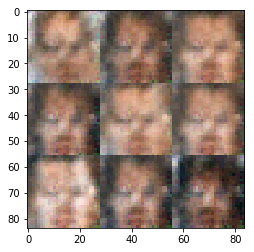

Epoch 2/2...  D loss: 1.1942  G loss: 0.9351
Epoch 2/2...  D loss: 1.0191  G loss: 1.0274
Epoch 2/2...  D loss: 0.9738  G loss: 1.1584
Epoch 2/2...  D loss: 0.9944  G loss: 1.3940
Epoch 2/2...  D loss: 1.1344  G loss: 1.0502
Epoch 2/2...  D loss: 0.9923  G loss: 1.1351
Epoch 2/2...  D loss: 1.1076  G loss: 1.6566
Epoch 2/2...  D loss: 1.2401  G loss: 1.6022
Epoch 2/2...  D loss: 1.1532  G loss: 1.6608
Epoch 2/2...  D loss: 0.9568  G loss: 1.3451


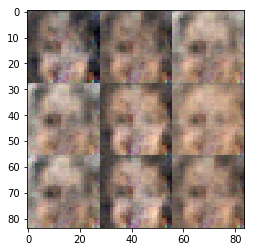

Epoch 2/2...  D loss: 1.0010  G loss: 1.1284
Epoch 2/2...  D loss: 1.2354  G loss: 0.9697
Epoch 2/2...  D loss: 1.2453  G loss: 0.9799
Epoch 2/2...  D loss: 1.2465  G loss: 0.7213
Epoch 2/2...  D loss: 1.1680  G loss: 1.0064
Epoch 2/2...  D loss: 1.1415  G loss: 0.9174
Epoch 2/2...  D loss: 1.1167  G loss: 0.8557
Epoch 2/2...  D loss: 1.0777  G loss: 0.9916
Epoch 2/2...  D loss: 1.0578  G loss: 0.9067
Epoch 2/2...  D loss: 1.2053  G loss: 0.8326


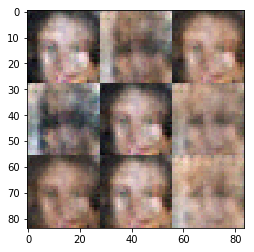

Epoch 2/2...  D loss: 1.0689  G loss: 1.1261
Epoch 2/2...  D loss: 1.1148  G loss: 0.8364
Epoch 2/2...  D loss: 1.1253  G loss: 0.9690
Epoch 2/2...  D loss: 0.9771  G loss: 1.0904
Epoch 2/2...  D loss: 1.2234  G loss: 1.6188
Epoch 2/2...  D loss: 0.9785  G loss: 1.1421
Epoch 2/2...  D loss: 1.0914  G loss: 1.2153
Epoch 2/2...  D loss: 1.0247  G loss: 1.1971
Epoch 2/2...  D loss: 1.0430  G loss: 0.8729
Epoch 2/2...  D loss: 1.0754  G loss: 1.0292


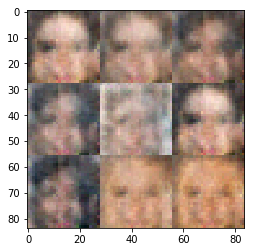

Epoch 2/2...  D loss: 0.9249  G loss: 1.1486
Epoch 2/2...  D loss: 1.0807  G loss: 1.2188
Epoch 2/2...  D loss: 1.1886  G loss: 0.8587
Epoch 2/2...  D loss: 1.0791  G loss: 0.8293
Epoch 2/2...  D loss: 1.0039  G loss: 1.2699
Epoch 2/2...  D loss: 1.1572  G loss: 0.7435
Epoch 2/2...  D loss: 1.0207  G loss: 0.8769
Epoch 2/2...  D loss: 1.0860  G loss: 1.0191
Epoch 2/2...  D loss: 1.1623  G loss: 0.9490
Epoch 2/2...  D loss: 1.0495  G loss: 0.7169


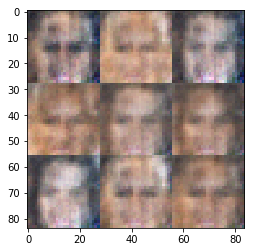

Epoch 2/2...  D loss: 1.1011  G loss: 1.0592
Epoch 2/2...  D loss: 1.0590  G loss: 1.0183
Epoch 2/2...  D loss: 1.3028  G loss: 0.8513
Epoch 2/2...  D loss: 1.1375  G loss: 0.9324
Epoch 2/2...  D loss: 1.1969  G loss: 0.9217
Epoch 2/2...  D loss: 1.0078  G loss: 1.2019
Epoch 2/2...  D loss: 1.0704  G loss: 0.9483
Epoch 2/2...  D loss: 1.0467  G loss: 1.1027
Epoch 2/2...  D loss: 1.1447  G loss: 0.9344
Epoch 2/2...  D loss: 1.2280  G loss: 1.4084


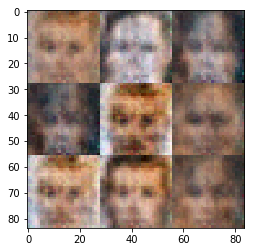

Epoch 2/2...  D loss: 0.9914  G loss: 1.1043
Epoch 2/2...  D loss: 1.0931  G loss: 0.9247
Epoch 2/2...  D loss: 1.1367  G loss: 1.0791
Epoch 2/2...  D loss: 1.1426  G loss: 0.9367
Epoch 2/2...  D loss: 1.1801  G loss: 0.8111
Epoch 2/2...  D loss: 1.2004  G loss: 1.0899
Epoch 2/2...  D loss: 1.2478  G loss: 0.9683
Epoch 2/2...  D loss: 1.1738  G loss: 1.2184
Epoch 2/2...  D loss: 1.1379  G loss: 1.0646
Epoch 2/2...  D loss: 1.1151  G loss: 1.0548


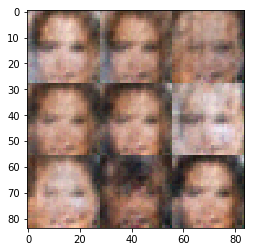

Epoch 2/2...  D loss: 1.1780  G loss: 0.9364
Epoch 2/2...  D loss: 1.1270  G loss: 1.0261
Epoch 2/2...  D loss: 1.2283  G loss: 1.0140
Epoch 2/2...  D loss: 1.1757  G loss: 0.9588
Epoch 2/2...  D loss: 1.1181  G loss: 0.9248
Epoch 2/2...  D loss: 1.1212  G loss: 0.9730
Epoch 2/2...  D loss: 1.1047  G loss: 0.9393
Epoch 2/2...  D loss: 1.1486  G loss: 1.0591
Epoch 2/2...  D loss: 1.0904  G loss: 1.1923
Epoch 2/2...  D loss: 1.1903  G loss: 0.9501


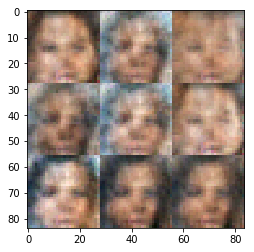

Epoch 2/2...  D loss: 0.9810  G loss: 1.3050
Epoch 2/2...  D loss: 1.0825  G loss: 1.3175
Epoch 2/2...  D loss: 1.0732  G loss: 1.0718
Epoch 2/2...  D loss: 1.2888  G loss: 1.0143
Epoch 2/2...  D loss: 1.1669  G loss: 0.9642
Epoch 2/2...  D loss: 1.3890  G loss: 0.8285
Epoch 2/2...  D loss: 1.0357  G loss: 1.0347
Epoch 2/2...  D loss: 1.2725  G loss: 0.7961
Epoch 2/2...  D loss: 1.0834  G loss: 1.1864
Epoch 2/2...  D loss: 1.1431  G loss: 1.1174


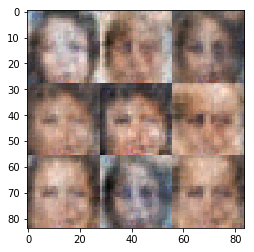

Epoch 2/2...  D loss: 1.1936  G loss: 1.0035
Epoch 2/2...  D loss: 1.0756  G loss: 0.9681
Epoch 2/2...  D loss: 1.1066  G loss: 1.1381
Epoch 2/2...  D loss: 1.0825  G loss: 0.9502
Epoch 2/2...  D loss: 1.1413  G loss: 0.8568
Epoch 2/2...  D loss: 1.0724  G loss: 1.0974
Epoch 2/2...  D loss: 1.2354  G loss: 0.9520
Epoch 2/2...  D loss: 1.1554  G loss: 0.9739
Epoch 2/2...  D loss: 1.1077  G loss: 1.2374
Epoch 2/2...  D loss: 1.1762  G loss: 0.8675


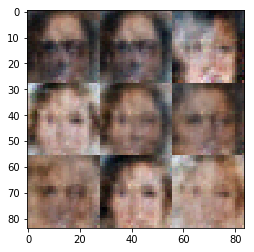

Epoch 2/2...  D loss: 1.0933  G loss: 1.1793
Epoch 2/2...  D loss: 1.2310  G loss: 1.0411
Epoch 2/2...  D loss: 1.0956  G loss: 1.0523
Epoch 2/2...  D loss: 1.2289  G loss: 0.7761
Epoch 2/2...  D loss: 1.1198  G loss: 1.0545
Epoch 2/2...  D loss: 1.2533  G loss: 0.7816
Epoch 2/2...  D loss: 1.2870  G loss: 0.7794
Epoch 2/2...  D loss: 1.1999  G loss: 0.8666
Epoch 2/2...  D loss: 1.2335  G loss: 0.7447
Epoch 2/2...  D loss: 1.2817  G loss: 0.8679


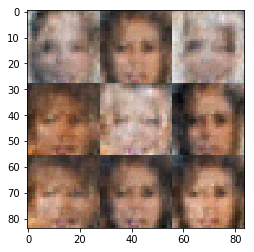

Epoch 2/2...  D loss: 1.2107  G loss: 0.9045
Epoch 2/2...  D loss: 1.2787  G loss: 0.8719
Epoch 2/2...  D loss: 1.2136  G loss: 0.7654
Epoch 2/2...  D loss: 1.2957  G loss: 0.8731
Epoch 2/2...  D loss: 1.2540  G loss: 0.8431
Epoch 2/2...  D loss: 1.1912  G loss: 1.1623
Epoch 2/2...  D loss: 1.3176  G loss: 0.8101
Epoch 2/2...  D loss: 1.2324  G loss: 1.0525
Epoch 2/2...  D loss: 1.3265  G loss: 0.8040
Epoch 2/2...  D loss: 1.2657  G loss: 0.8159


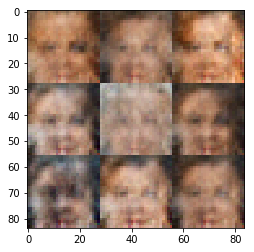

Epoch 2/2...  D loss: 1.3272  G loss: 0.9839
Epoch 2/2...  D loss: 1.1924  G loss: 0.8352
Epoch 2/2...  D loss: 1.3925  G loss: 0.7683
Epoch 2/2...  D loss: 1.0923  G loss: 1.1442
Epoch 2/2...  D loss: 1.3989  G loss: 0.9582
Epoch 2/2...  D loss: 1.0941  G loss: 0.9477


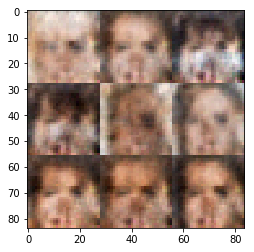

In [33]:
#batch_size = 200 # 1152
#z_dim = 100
#learning_rate = 0.001
#beta1 = 0.5

# AE: Continuing with the weights from MNIST section
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
alpha=0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.